In [1]:
import sys
sys.path.append("..")

from glob import glob
import matplotlib.pyplot as plt
import ipywidgets as ipw
import numpy as np 
from tqdm.notebook import tqdm
from imitative_agent import ImitativeAgent
from lib.dataset_wrapper import Dataset
from lib import utils
from lib import abx_utils

current path: /mnt/c/Users/vpaul/OneDrive - CentraleSupelec/Inner_Speech/agent/imitative_agent_inner_speech_silent_finetune


In [7]:
ABX_NB_SAMPLES = 50
AGENT_ABX_DISTANCES = [
    {"art_estimated": {
            "metric": "euclidean",
            "weight": 1,
        },
    }
]

In [8]:
# Get paths to all trained agents

agents_path = glob("../out/imitative_agent_inner_speech_silent_finetune_nojerk7/*/")
agents_path.sort()
print(f"Found {len(agents_path)} agents")

# Dictionary to store agent aliases mapped to their paths
agents_alias = {}

for agent_path in agents_path:
    # Load agent configuration without neural networks for efficiency
    agent = ImitativeAgent.reload(agent_path, load_nn=False)
    config = agent.config
        
    # Get agent identifier from path
    agent_i = agent_path[-2] 
    
    # Handle nb_derivatives, always equal to 0 in our implementation
    try:
        nb_derivatives = config['model']['direct_model']['nb_derivatives']
    except:
        nb_derivatives = 0
        
    # Create descriptive alias string containing key agent parameters
    agent_alias = " ".join((
        f"{','.join(config['dataset']['names'])}",  # Dataset names
        f"synth_art={agent.synthesizer.config['dataset']['art_type']}", # Articulatory features type
        f"nd={nb_derivatives}", # Number of derivatives
        f"jerk={config['training']['jerk_loss_weight']}", # Jerk loss weight
        f"({agent_i})", # Agent identifier
    ))
    
    # Print agent information
    print(f"\nPath: {agent_path}")
    print(f"- Datasets: {config['dataset']['names']}")
    print(f"- Synthesizer art type: {agent.synthesizer.config['dataset']['art_type']}")
    print(f"- Jerk loss weight: {config['training']['jerk_loss_weight']}")
    
    # Store mapping between alias and path
    agents_alias[agent_alias] = agent_path

Found 30 agents
{'dataset': {'batch_size': 8, 'datasplits_size': [64, 16, 20], 'names': ['pb2007'], 'num_workers': 6, 'shuffle_between_epochs': True, 'sound_type': 'cepstrum'}, 'model': {'direct_model': {'activation': 'relu', 'batch_norm': True, 'dropout_p': 0.25, 'hidden_layers': [256, 256, 256, 256]}, 'inverse_model': {'bidirectional': True, 'dropout_p': 0.25, 'hidden_size': 32, 'num_layers': 2}}, 'synthesizer': {'name': 'ea587b76c95fecef01cfd16c7f5f289d-0/'}, 'training': {'jerk_loss_ceil': 0, 'jerk_loss_weight': 0, 'learning_rate': 0.001, 'max_epochs': 800, 'patience': 100, 'vel_loss_ceil': 0, 'vel_loss_weight': 0}}
{'direct_model': {'activation': 'relu', 'batch_norm': True, 'dropout_p': 0.25, 'hidden_layers': [256, 256, 256, 256]}, 'inverse_model': {'bidirectional': True, 'dropout_p': 0.25, 'hidden_size': 32, 'num_layers': 2}}
{'direct_model': {'activation': 'relu', 'batch_norm': True, 'dropout_p': 0.25, 'hidden_layers': [256, 256, 256, 256]}, 'inverse_model': {'bidirectional': Tru

In [3]:
# Get paths to all trained agents

agents_path = glob("../out/imitative_agent_inner_speech_silent_finetune_nojerk7/*/")
agents_path.sort()
print(f"Found {len(agents_path)} agents")

# Dictionary to store agent aliases mapped to their paths
agents_alias = {}

for agent_path in agents_path:
    agent = ImitativeAgent.reload(agent_path, load_nn=False)
    config = agent.config
        
    agent_i = agent_path[-2]
    agent_alias = " ".join((
        f"{','.join(config['dataset']['names'])}",
        f"synth_art={agent.synthesizer.config['dataset']['art_type']}",
        f"jerk_c={config['training']['jerk_loss_ceil']}",
        f"jerk_w={config['training']['jerk_loss_weight']}",
        f"bi={config['model']['inverse_model']['bidirectional']}",
        f"({agent_i})",
    ))
    
    agents_alias[agent_alias] = agent_path

{'dataset': {'batch_size': 8, 'datasplits_size': [64, 16, 20], 'names': ['pb2007'], 'num_workers': 6, 'shuffle_between_epochs': True, 'sound_type': 'cepstrum'}, 'model': {'direct_model': {'activation': 'relu', 'batch_norm': True, 'dropout_p': 0.25, 'hidden_layers': [256, 256, 256, 256]}, 'inverse_model': {'bidirectional': True, 'dropout_p': 0.25, 'hidden_size': 32, 'num_layers': 2}}, 'synthesizer': {'name': 'ea587b76c95fecef01cfd16c7f5f289d-0/'}, 'training': {'jerk_loss_ceil': 0, 'jerk_loss_weight': 0, 'learning_rate': 0.001, 'max_epochs': 800, 'patience': 100, 'vel_loss_ceil': 0, 'vel_loss_weight': 0}}
{'direct_model': {'activation': 'relu', 'batch_norm': True, 'dropout_p': 0.25, 'hidden_layers': [256, 256, 256, 256]}, 'inverse_model': {'bidirectional': True, 'dropout_p': 0.25, 'hidden_size': 32, 'num_layers': 2}}
{'direct_model': {'activation': 'relu', 'batch_norm': True, 'dropout_p': 0.25, 'hidden_layers': [256, 256, 256, 256]}, 'inverse_model': {'bidirectional': True, 'dropout_p': 

In [9]:
import torch
agents_abx_matrices = utils.pickle_load("../out/imitative_agent/abx_cache.pickle", {})
print(agents_alias.items())
for agent_alias, agent_path in tqdm(agents_alias.items()):
    print(f"\nProcessing agent: {agent_alias}")

    # Load agent and get dataset info
    agent = ImitativeAgent.reload(agent_path)
    main_dataset = agent.get_main_dataset()
    agent_lab = agent.get_datasplit_lab(2)
    agent_features = agent.repeat_overt_datasplit(2) # use repeat_overt_datasplit or repeat_inner_datasplit to get features for the inner or overt repetitions

    # Get phoneme information
    consonants = main_dataset.phones_infos["consonants"]
    vowels = main_dataset.phones_infos["vowels"]
    print(f"Number of consonants: {len(consonants)}")
    print(f"Number of vowels: {len(vowels)}")
    
    # Get indices of consonants in dataset
    consonants_indexes = abx_utils.get_datasets_phones_indexes(agent_lab, consonants, vowels)
    
    # Initialize ABX matrices for this agent if not already cached
    if agent_path not in agents_abx_matrices:
        agents_abx_matrices[agent_path] = {}
    agent_abx_matrices = agents_abx_matrices[agent_path]
    
    # Calculate ABX matrices for each distance metric
    for distance in AGENT_ABX_DISTANCES:
        distance_signature = abx_utils.get_distance_signature(distance)
        
        if distance_signature in agent_abx_matrices:
            print(f"Using cached ABX matrix for {distance_signature}")
            continue
            
        print(f"Computing ABX matrix for {distance_signature}")
        abx_matrix = abx_utils.get_abx_matrix(consonants, consonants_indexes, 
                                            agent_features, distance, ABX_NB_SAMPLES)
        
        # Cache the computed matrix
        agent_abx_matrices[distance_signature] = abx_matrix
        utils.pickle_dump("../out/imitative_agent/abx_cache.pickle", agents_abx_matrices)
        print(f"Saved ABX matrix for {distance_signature}")

dict_items([('pb2007 synth_art=art_params nd=0 jerk=0 (0)', '../out/imitative_agent_inner_speech_silent_finetune_nojerk7/221ef425ed39aae2095ac359cca74959-20/'), ('pb2007 synth_art=art_params nd=0 jerk=0 (1)', '../out/imitative_agent_inner_speech_silent_finetune_nojerk7/221ef425ed39aae2095ac359cca74959-21/'), ('pb2007 synth_art=art_params nd=0 jerk=0 (2)', '../out/imitative_agent_inner_speech_silent_finetune_nojerk7/221ef425ed39aae2095ac359cca74959-22/'), ('pb2007 synth_art=art_params nd=0 jerk=0 (3)', '../out/imitative_agent_inner_speech_silent_finetune_nojerk7/221ef425ed39aae2095ac359cca74959-3/'), ('pb2007 synth_art=art_params nd=0 jerk=0 (4)', '../out/imitative_agent_inner_speech_silent_finetune_nojerk7/221ef425ed39aae2095ac359cca74959-4/'), ('pb2007 synth_art=art_params nd=0 jerk=0 (5)', '../out/imitative_agent_inner_speech_silent_finetune_nojerk7/221ef425ed39aae2095ac359cca74959-5/'), ('pb2007 synth_art=art_params nd=0 jerk=0 (6)', '../out/imitative_agent_inner_speech_silent_finet

  0%|          | 0/10 [00:00<?, ?it/s]


Processing agent: pb2007 synth_art=art_params nd=0 jerk=0 (0)
{'dataset': {'batch_size': 8, 'datasplits_size': [64, 16, 20], 'names': ['pb2007'], 'num_workers': 6, 'shuffle_between_epochs': True, 'sound_type': 'cepstrum'}, 'model': {'direct_model': {'activation': 'relu', 'batch_norm': True, 'dropout_p': 0.25, 'hidden_layers': [256, 256, 256, 256]}, 'inverse_model': {'bidirectional': True, 'dropout_p': 0.25, 'hidden_size': 32, 'num_layers': 2}}, 'synthesizer': {'name': 'ea587b76c95fecef01cfd16c7f5f289d-0/'}, 'training': {'jerk_loss_ceil': 0, 'jerk_loss_weight': 0, 'learning_rate': 0.001, 'max_epochs': 800, 'patience': 100, 'vel_loss_ceil': 0, 'vel_loss_weight': 0}}
{'direct_model': {'activation': 'relu', 'batch_norm': True, 'dropout_p': 0.25, 'hidden_layers': [256, 256, 256, 256]}, 'inverse_model': {'bidirectional': True, 'dropout_p': 0.25, 'hidden_size': 32, 'num_layers': 2}}
{'direct_model': {'activation': 'relu', 'batch_norm': True, 'dropout_p': 0.25, 'hidden_layers': [256, 256, 256

In [6]:
import torch
agents_abx_matrices = utils.pickle_load("../out/imitative_agent/abx_cache.pickle", {})
print(agents_alias.items())
for agent_alias, agent_path in tqdm(agents_alias.items()):
    agent = ImitativeAgent.reload(agent_path)
    
    main_dataset = agent.get_main_dataset()
    agent_lab = agent.get_datasplit_lab(2)
    agent_features = agent.repeat_overt_datasplit(2) # use repeat_overt_datasplit or repeat_inner_datasplit to get features for the inner or overt repetitions

    consonants = main_dataset.phones_infos["consonants"]
    vowels = main_dataset.phones_infos["vowels"]
    consonants_indexes = abx_utils.get_datasets_phones_indexes(agent_lab, consonants, vowels)
    print(f"agent features : {agent_features}")
    if agent_path not in agents_abx_matrices:
        agents_abx_matrices[agent_path] = {}
    agent_abx_matrices = agents_abx_matrices[agent_path]
    
    for distance in AGENT_ABX_DISTANCES:
        distance_signature = abx_utils.get_distance_signature(distance)
        if distance_signature in agent_abx_matrices: continue
        abx_matrix = abx_utils.get_abx_matrix(consonants, consonants_indexes, agent_features, distance, ABX_NB_SAMPLES)
        
        agent_abx_matrices[distance_signature] = abx_matrix
        utils.pickle_dump("../out/imitative_agent/abx_cache.pickle", agents_abx_matrices)

dict_items([('pb2007 synth_art=art_params jerk_c=0 jerk_w=0 bi=True (4)', '../out/imitative_agent_inner_speech_silent_finetune_nojerk7/221ef425ed39aae2095ac359cca74959-4/')])


  0%|          | 0/1 [00:00<?, ?it/s]

{'dataset': {'batch_size': 8, 'datasplits_size': [64, 16, 20], 'names': ['pb2007'], 'num_workers': 6, 'shuffle_between_epochs': True, 'sound_type': 'cepstrum'}, 'model': {'direct_model': {'activation': 'relu', 'batch_norm': True, 'dropout_p': 0.25, 'hidden_layers': [256, 256, 256, 256]}, 'inverse_model': {'bidirectional': True, 'dropout_p': 0.25, 'hidden_size': 32, 'num_layers': 2}}, 'synthesizer': {'name': 'ea587b76c95fecef01cfd16c7f5f289d-0/'}, 'training': {'jerk_loss_ceil': 0, 'jerk_loss_weight': 0, 'learning_rate': 0.001, 'max_epochs': 800, 'patience': 100, 'vel_loss_ceil': 0, 'vel_loss_weight': 0}}
{'direct_model': {'activation': 'relu', 'batch_norm': True, 'dropout_p': 0.25, 'hidden_layers': [256, 256, 256, 256]}, 'inverse_model': {'bidirectional': True, 'dropout_p': 0.25, 'hidden_size': 32, 'num_layers': 2}}
{'direct_model': {'activation': 'relu', 'batch_norm': True, 'dropout_p': 0.25, 'hidden_layers': [256, 256, 256, 256]}, 'inverse_model': {'bidirectional': True, 'dropout_p': 

NameError: name 'agent_groups_score' is not defined

{'dataset': {'batch_size': 8, 'datasplits_size': [64, 16, 20], 'names': ['pb2007'], 'num_workers': 6, 'shuffle_between_epochs': True, 'sound_type': 'cepstrum'}, 'model': {'direct_model': {'activation': 'relu', 'batch_norm': True, 'dropout_p': 0.25, 'hidden_layers': [256, 256, 256, 256]}, 'inverse_model': {'bidirectional': True, 'dropout_p': 0.25, 'hidden_size': 32, 'num_layers': 2}}, 'synthesizer': {'name': 'ea587b76c95fecef01cfd16c7f5f289d-0/'}, 'training': {'jerk_loss_ceil': 0, 'jerk_loss_weight': 0, 'learning_rate': 0.001, 'max_epochs': 800, 'patience': 100, 'vel_loss_ceil': 0, 'vel_loss_weight': 0}}
{'direct_model': {'activation': 'relu', 'batch_norm': True, 'dropout_p': 0.25, 'hidden_layers': [256, 256, 256, 256]}, 'inverse_model': {'bidirectional': True, 'dropout_p': 0.25, 'hidden_size': 32, 'num_layers': 2}}
{'direct_model': {'activation': 'relu', 'batch_norm': True, 'dropout_p': 0.25, 'hidden_layers': [256, 256, 256, 256]}, 'inverse_model': {'bidirectional': True, 'dropout_p': 

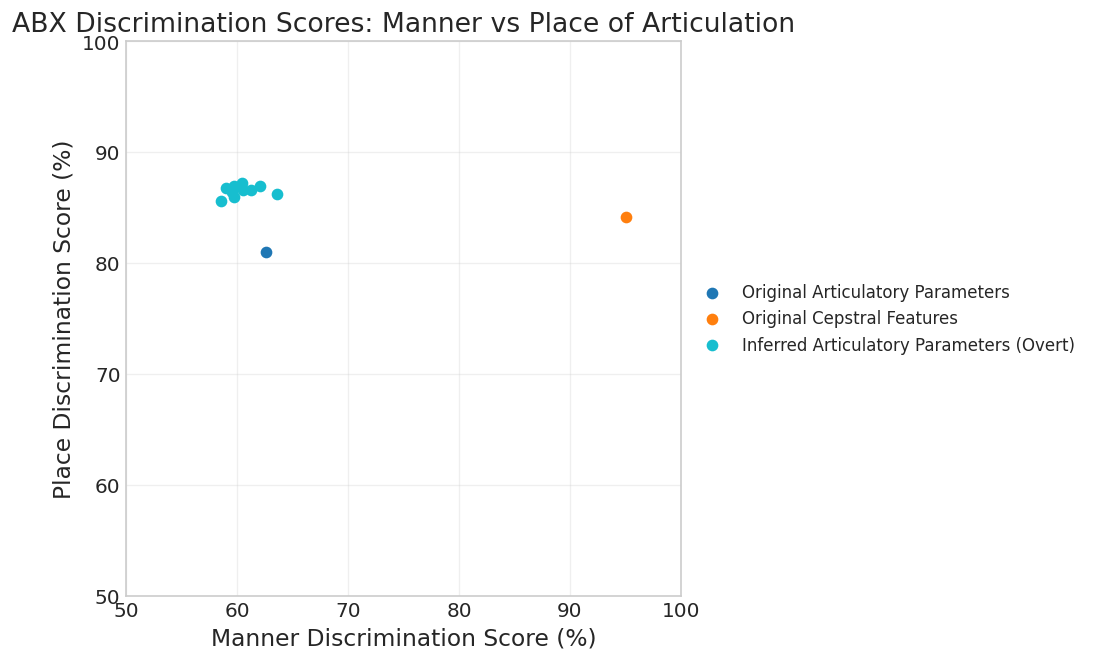

In [ ]:
# Threshold for jerk loss ceiling in model selection
CEIL = 0

# Reference ABX scores for comparison
# Scores for manner and place of articulation discrimination
# Using articulatory parameters and cepstral features as baselines
# # plosives + fricatives
# abx_art_params = {'manner': 62.73333333333334, 'place': 80.25}
# abx_cepstrum = {'manner': 95.3, 'place': 73.75}
# fricatives only
abx_art_params = {'manner': 62.63333333333333, 'place': 81.0}  # Articulatory parameters baseline
abx_cepstrum = {'manner': 95.1, 'place': 84.16666666666667}    # Cepstral features baseline

# Generate ABX discrimination plots for each distance metric
for distance in AGENT_ABX_DISTANCES:
    distance_signature = abx_utils.get_distance_signature(distance)
    
    # Create figure with equal aspect ratio for fair visual comparison
    plt.figure(dpi=120)
    ax = plt.subplot(aspect="equal")
    
    # Set consistent axis limits and labels
    ax.set_xlim(50, 100)
    ax.set_ylim(50, 100)
    ax.set_xlabel("Manner Discrimination Score (%)")
    ax.set_ylabel("Place Discrimination Score (%)")
    ax.set_title("ABX Discrimination Scores: Manner vs Place of Articulation")

    # Plot baseline performance points
    ax.scatter(abx_art_params["manner"], abx_art_params["place"], 
              c="tab:blue", label="Original Articulatory Parameters")
    ax.scatter(abx_cepstrum["manner"], abx_cepstrum["place"], 
              c="tab:orange", label="Original Cepstral Features")
    ax.scatter(0, 0, c="tab:cyan", 
              label="Inferred Articulatory Parameters (Overt)")

    # Position legend outside plot to avoid overlap
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Evaluate and plot results for each agent configuration
    for agent_alias, agent_path in agents_alias.items():
        agent = ImitativeAgent.reload(agent_path, load_nn=False)
        dataset = agent.get_main_dataset()
        
        # Determine plot color based on model configuration
        color = "tab:red"  # Default color
        if agent.config["training"]["jerk_loss_weight"] == .1:
            color = "tab:pink"
        elif agent.config["training"]["jerk_loss_weight"] == 1:
            color = "tab:green"
        elif agent.config["model"]["inverse_model"]["bidirectional"]:
            color = "tab:cyan"
            
        # Skip agents with different jerk loss ceiling
        if agent.config["training"]["jerk_loss_ceil"] != CEIL:
            continue

        # Get ABX discrimination matrix for current agent
        agent_abx_matrix = agents_abx_matrices[agent_path][distance_signature]
        
        # Get consonant groupings from dataset
        consonant_groups = dataset.phones_infos["consonant_groups"].copy()
        # consonant_groups["manner"] = [['f', 'v', 'm'], ['s', 'z', 'n'], ['s^', 'z^', 'r']]
        # consonant_groups["place"] = [['f', 's', 's^'], ['v', 'z', 'z^']]
        # consonant_groups["place"] = [['p', 't', 'k'], ['b', 'd', 'g']]
        
        # Calculate and plot discrimination scores for manner and place
        agent_groups_score = abx_utils.get_groups_score(consonants, 
                                                      agent_abx_matrix, 
                                                      consonant_groups)
        ax.scatter(agent_groups_score["manner"], 
                  agent_groups_score["place"], 
                  c=color)
    
    plt.show()

In [10]:
print(agent_groups_score)

NameError: name 'agent_groups_score' is not defined